# Deep Pensieve™
A Deep Residual MMD Variational Auto-Encoder with Group Normalization (GN), Efficient Sub-Pixel Convolution Super-Resolution (ESPCN), and Perceptual Similarity Loss (SSIM)

<table><tr>
<td><img src='https://s3.amazonaws.com/neurokinetikz/latent-animation-1540551741.4923084-final.gif'></td>
<td><img src='https://s3.amazonaws.com/neurokinetikz/latent-animation-1540552110.470284-final.gif'></td>
<td><img src="https://s3.amazonaws.com/neurokinetikz/1542113809.6163912-080.gif"></td>
<td><img src='https://s3.amazonaws.com/neurokinetikz/latent-animation-1540552122.395882-final.gif'></td>
<td><img src='https://s3.amazonaws.com/neurokinetikz/latent-animation-1540551578.5925505-final.gif'></td>
</tr></table>

## Multi-Stage Variational Auto-Encoders for Coarse-to-Fine Image Generation 

https://arxiv.org/abs/1705.07202

<img src="https://s3.amazonaws.com/neurokinetikz/download-1.png">

Variational auto-encoder (VAE) is a powerful unsupervised learning framework for image generation. One drawback of VAE is that it generates blurry images due to its Gaussianity assumption and thus L2 loss. To allow the generation of high quality images by VAE, we increase the capacity of decoder network by employing residual blocks and skip connections, which also enable efficient optimization. To overcome the limitation of L2 loss, we propose to generate images in a multi-stage manner from coarse to fine. In the simplest case, the proposed multi-stage VAE divides the decoder into two components in which the second component generates refined images based on the course images generated by the first component. Since the second component is independent of the VAE model, it can employ other loss functions beyond the L2 loss and different model architectures. The proposed framework can be easily generalized to contain more than two components. Experiment results on the MNIST and CelebA datasets demonstrate that the proposed multi-stage VAE can generate sharper images as compared to those from the original VAE.

## Imports

In [1]:
import time
import json
import random
import numpy as np
import tensorflow as tf

from libs import utils, gif
from libs.group_norm import GroupNormalization

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, Flatten, Reshape, Add, Multiply, Activation, Lambda
from keras.layers import Dense, Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D
from keras.callbacks import LambdaCallback

from keras import optimizers
from keras import backend as K

from keras_contrib.losses import DSSIMObjective
from keras_contrib.layers.convolutional import SubPixelUpscaling

Using TensorFlow backend.


## Load Images

In [4]:
DIRECTORY = 'roadtrip'

SIZE = 128
CHANNELS = 3

FEATURES = SIZE*SIZE*CHANNELS
FEATURES_2X = 2*SIZE*2*SIZE*CHANNELS

MODEL_NAME = DIRECTORY+'-'+str(SIZE)

In [5]:
# load images
imgs, xs, ys  = utils.load_images(directory="imgs/"+DIRECTORY,rx=SIZE,ry=SIZE)
imgs_2x, xs_2x, ys_2x = utils.load_images(directory="imgs/"+DIRECTORY,rx=2*SIZE,ry=2*SIZE)

# normalize pixels
IMGS = imgs/127.5 - 1
FLAT = np.reshape(IMGS,(-1,FEATURES))

IMGS_2X = imgs_2x/127.5 - 1
FLAT_2X = np.reshape(IMGS_2X,(-1,FEATURES_2X)) 

SAMPLES =  np.random.permutation(FLAT)[:9]
SAMPLES_2X =  np.random.permutation(FLAT_2X)[:9]

TOTAL_BATCH = IMGS.shape[0]

# print shapes
print("MODEL: ",MODEL_NAME)
print("IMGS: ",IMGS.shape,IMGS_2X.shape)
print("FLAT: ",FLAT.shape,FLAT_2X.shape)
print("SAMPLES: ",SAMPLES.shape,SAMPLES_2X.shape)

Loading images:	184
Loading images:	184
MODEL:  roadtrip-128
IMGS:  (184, 128, 128, 3) (184, 256, 256, 3)
FLAT:  (184, 49152) (184, 196608)
SAMPLES:  (9, 49152) (9, 196608)


### Very Deep Convolutional Networks for Large-Scale Image Recognition 

https://arxiv.org/abs/1409.1556

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_3/CascadingConvolutions.png">

In this work we investigate the effect of the convolutional network depth on its accuracy in the large-scale image recognition setting. Our main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3×3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16–19 weight layers.

First, we incorporate three non-linear rectification layers instead of a single one, which makes the decision function more discriminative.

Second, we decrease the number of parameters: assuming that both the input and the output of a
three-layer 3 × 3 convolution stack has C channels, the stack is parametrised by (W) weights; at the same time, a single 7 × 7 conv. layer would require 81% more. This can be seen as imposing a regularisation on the 7 × 7 conv. filters, forcing them to have a decomposition through the 3 × 3 filters (with non-linearity injected in between)

## Group Normalization

https://medium.com/syncedreview/facebook-ai-proposes-group-normalization-alternative-to-batch-normalization-fb0699bffae7

<img src="https://s3.amazonaws.com/neurokinetikz/groupnorm.png">


The mainstream normalization technique for almost all convolutional neural networks today is Batch Normalization (BN), which has been widely adopted in the development of deep learning. Proposed by Google in 2015, BN can not only accelerate a model’s converging speed, but also alleviate problems such as Gradient Dispersion in the deep neural network, making it easier to train models.

Dr. Wu and Dr. He however argue in their paper Group Normalization that normalizing with batch size has limitations, as BN cannot ensure the model accuracy rate when the batch size becomes smaller. As a result, researchers today are normalizing with large batches, which is very memory intensive, and are avoiding using limited memory to explore higher-capacity models.

Dr. Wu and Dr. He believe their new GN technique is a simple but effective alternative to BN. Specifically, GN divides channels — also referred to as feature maps that look like 3D chunks of data — into groups and normalizes the features within each group. GN only exploits the layer dimensions, and its computation is independent of batch sizes.

The paper reports that GN had a 10.6% lower error rate than its BN counterpart for ResNet-50 in ImageNet with a batch size of 2 samples; and matched BN performance while outperforming other normalization techniques with a regular batch size.

## Encoder

In [6]:
def encode(x):
    # set current layer
    current_layer = Reshape((SIZE,SIZE,CHANNELS))(x)
    
    # convolution layers
    for layer, n_filters in enumerate(FILTERS):

        # stacked 3x3 convolutions with group normalization + activation
        current_layer = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)(current_layer)
        current_layer = GroupNormalization(groups=n_filters,axis=-1)(current_layer)
        current_layer = Activation(ACTIVATION)(current_layer)

        current_layer = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)(current_layer)
        current_layer = GroupNormalization(groups=n_filters,axis=-1)(current_layer)
        current_layer = Activation(ACTIVATION)(current_layer)
         
        # max pooling
        current_layer = MaxPooling2D()(current_layer)
    
    # grab the last shape for reconstruction
    shape = current_layer.get_shape().as_list()
    
    # flatten
    flat = Flatten()(current_layer)
    
    # latent vector
    z = Dense(LATENT_DIM,name='encoder')(flat)
    
    return z, (shape[1],shape[2],shape[3])

## Maximum Mean Discrepancy 

https://ermongroup.github.io/blog/a-tutorial-on-mmd-variational-autoencoders/

<table><tr>
<td><img src="https://s3.amazonaws.com/neurokinetikz/kl_latent.gif" ></td>
<td><img src="https://s3.amazonaws.com/neurokinetikz/mmd_latent.gif" ></td>
</tr></table>

Maximum mean discrepancy (MMD, (Gretton et al. 2007)) is based on the idea that two distributions are identical if and only if all their moments are the same. Therefore, we can define a divergence by measuring how “different” the moments of two distributions p(z) and q(z) are. MMD can accomplish this efficiently via the kernel embedding trick:

A kernel can be intuitively interpreted as a function that measures the “similarity” of two samples. It has a large value when two samples are similar, and small when they are different. For example, the Gaussian kernel considers points that are close in Euclidean space to be “similar”. A rough intuition of MMD, then, is that if two distributions are identical, then the average “similarity” between samples from each distribution, should be identical to the average “similarity” between mixed samples from both distributions.



In [7]:
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [8]:
def vae_loss(y_true,y_pred):
    epsilon = tf.random_normal(tf.stack([BATCH_SIZE, LATENT_DIM]))
    latent_loss = compute_mmd(epsilon, y_pred)
    return latent_loss

## Deconvolution and Checkerboard Artifacts 

https://distill.pub/2016/deconv-checkerboard/

When we have neural networks generate images, we often have them build them up from low resolution, high-level descriptions. This allows the network to describe the rough image and then fill in the details.

In order to do this, we need some way to go from a lower resolution image to a higher one. We generally do this with the deconvolution operation. Roughly, deconvolution layers allow the model to use every point in the small image to “paint” a square in the larger one.

Unfortunately, deconvolution can easily have “uneven overlap,” putting more of the metaphorical paint in some places than others. In particular, deconvolution has uneven overlap when the kernel size (the output window size) is not divisible by the stride (the spacing between points on the top). While the network could, in principle, carefully learn weights to avoid this  — as we’ll discuss in more detail later — in practice neural networks struggle to avoid it completely.

<img src="https://s3.amazonaws.com/neurokinetikz/download-2.png">

To avoid these artifacts, we’d like an alternative to regular deconvolution (“transposed convolution”). Unlike deconvolution, this approach to upsampling shouldn’t have artifacts as its default behavior. Ideally, it would go further, and be biased against such artifacts.

One approach is to separate out upsampling to a higher resolution from convolution to compute features. For example, you might resize the image (using nearest-neighbor interpolation or bilinear interpolation) and then do a convolutional layer. This seems like a natural approach, and roughly similar methods have worked well in image super-resolution.

Our experience has been that nearest-neighbor resize followed by a convolution works very well, in a wide variety of contexts.

## Decoder

In [9]:
def decode(z,z_g,shape=None):
    
    # reverse the encoder
    filters = FILTERS[::-1]

    # inflate
    inflated = shape[0]*shape[1]*shape[2]
    inflate = Dense(inflated,name='generator')
    current_layer = inflate(z) ; generator = inflate(z_g)
    
    # reshape
    reshape = Reshape(shape)
    current_layer = reshape(current_layer) ; generator = reshape(generator)
    
    # build layers
    for layer, n_filters in enumerate(filters):
        
        # upsample
        u = UpSampling2D()
        current_layer = u(current_layer) ; generator = u(generator)

        # stacked 3x3 convolutions with group normalization + activation
        c1 = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)
        b1 = GroupNormalization(groups=n_filters,axis=-1)
        a1 = Activation(ACTIVATION)

        current_layer = c1(current_layer) ; generator = c1(generator)
        current_layer = b1(current_layer) ; generator = b1(generator)
        current_layer = a1(current_layer) ; generator = a1(generator)

        c2 = Conv2D(n_filters,3,padding='SAME',kernel_initializer=INITIALIZER)
        b2 = GroupNormalization(groups=n_filters,axis=-1)
        a2 = Activation(ACTIVATION)

        current_layer = c2(current_layer) ; generator = c2(generator)
        current_layer = b2(current_layer) ; generator = b2(generator)
        current_layer = a2(current_layer) ; generator = a2(generator)
    
    # output convolution + activation
    conv = Conv2D(CHANNELS,1,padding='SAME',kernel_initializer=INITIALIZER_TANH)
    activation = Activation('tanh',name='decoder_dssim')
    
    current_layer = conv(current_layer)       ; generator = conv(generator)
    current_layer = activation(current_layer) ; generator = activation(generator)
    
    flatten = Flatten(name='decoder')
    decoder_loss = flatten(current_layer)
    
    return current_layer, generator, decoder_loss

## Enhanced Deep Residual Networks for Single Image Super-Resolution

https://arxiv.org/abs/1707.02921

<img src="https://s3.amazonaws.com/neurokinetikz/download-3.png">

Recently, residual networks exhibit excellent performance in computer vision problems from the lowlevel to high-level tasks. Although Ledig et al. successfully applied the ResNet architecture to the super-resolution problem with SRResNet, we further improve the performance by employing better ResNet structure.

We remove the batch normalization layers from our network as Nah et al.[19] presented in their image deblurring work. Since batch normalization layers normalize the features, they get rid of range flexibility from networks by normalizing the features, it is better to remove them. We experimentally show that this simple modification increases the performance substantially as detailed in

Furthermore, GPU memory usage is also sufficiently reduced since the batch normalization layers consume the same amount of memory as the preceding convolutional layers. Our baseline model without batch normalization layer saves approximately 40% of memory usage during training, compared to SRResNet. Consequently, we can build up a larger model that has better performance than conventional ResNet structure under limited computational resources.

### Xception: Deep Learning with Depthwise Separable Convolutions

https://arxiv.org/abs/1610.02357

<img width="600" src="https://s3.amazonaws.com/neurokinetikz/Screen+Shot+2018-11-24+at+11.19.12+AM.png">

https://stackoverflow.com/questions/52248655/depthwise-separable-convolution/52550451

The intuition behind doing this is to decouple the spatial information (width and height) and the depthwise information (channels). While regular convolutional layers will merge feature maps over the number of input channels, depthwise separable convolutions will perform another 1x1 convolution before adding them up.

Using a depthwise separable convolutional layer as a drop-in replacement for a regular one will greatly reduce the number of weights in the model. It will also very likely hurt the accuracy due to the much smaller number of weights. However, if you change the width and depth of your architecture to increase the weights again, you may reach the same accuracy of the original model with less parameters. At the same time a depthwise separable model with the same number of weights might achieve a higher accuracy compared the original model.

## Residual

In [11]:
def residual(x,x_g):
    
    current_layer = x ; generator = x_g

    # shortcuts
    shortcut = current_layer 
    shortcut_g = generator

    # conv 1
    c1 = SeparableConv2D(R_FILTERS,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c1(current_layer) ; generator = c1(generator)
    
    # activation 1
    a1 = Activation(ACTIVATION)
    current_layer = a1(current_layer) ; generator = a1(generator)

    # conv 2
    c2 = SeparableConv2D(R_FILTERS,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c2(current_layer) ; generator = c2(generator)

    # residual scaling
    scale = Lambda(lambda x: x * R_SCALING)
    current_layer = scale(current_layer) ; generator = scale(generator)

    # fix shortcut shape if mismatch
    if(shortcut.shape[-1] != current_layer.shape[-1]):
        s = SeparableConv2D(R_FILTERS,1,padding='SAME',kernel_initializer=INITIALIZER)
        shortcut = s(current_layer) ; shortcut_g = s(generator)
        
    # merge shortcut
    merge = Add()
    current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])

    return current_layer, generator

## Refiner

https://arxiv.org/abs/1707.02921

<img width=500 src="https://s3.amazonaws.com/neurokinetikz/Screen+Shot+2018-11-18+at+8.54.43+AM.png">

Recently, the powerful capability of deep neural networks has led to dramatic improvements in SR. Since Dong et al. [4, 5] first proposed a deep learning-based SR method, various CNN architectures have been studied for SR. Kim et al. [11, 12] first introduced the residual network for training much deeper network architectures and achieved superior performance. In particular, they showed that skip connection and recursive convolution alleviate the burden of carrying identity information in the super-resolution network. Similarly to [20], Mao et al. [16] tackled the general image restoration problem with encoder-decoder networks and symmetric skip connections. In [16], they argue that those nested skip connections provide fast and improved convergence.

In [10]:
def refine(x,x_g):
    conv1 = Conv2D(CHANNELS,1,padding='SAME',kernel_initializer=INITIALIZER_TANH)
    current_layer = conv1(x) ; generator = conv1(x_g)
    
    shortcut = current_layer; shortcut_g = generator

    for i in range(R_LAYERS):
        current_layer, generator = residual(current_layer, generator)
#     for i in range(R_GROUPS):
#         current_layer, generator = residual_group(current_layer,generator)
    
    conv2 = Conv2D(CHANNELS,1,padding='SAME',kernel_initializer=INITIALIZER_TANH)
    current_layer = conv2(current_layer); generator = conv2(generator)
    
    merge = Add()
    current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])
    
    activation = Activation('tanh',name='refiner_dssim')
    current_layer = activation(current_layer) ; generator = activation(generator)
    
    flatten = Flatten(name='refiner')
    refiner_loss = flatten(current_layer)
    
    return current_layer, generator, refiner_loss

### Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network 

https://arxiv.org/abs/1609.05158

<img width="75%" src="https://s3.amazonaws.com/neurokinetikz/Screen+Shot+2018-11-23+at+10.26.45+AM.png">

Recently, several models based on deep neural networks have achieved great success in terms of both reconstruction accuracy and computational performance for single image super-resolution. In these methods, the low resolution (LR) input image is upscaled to the high resolution (HR) space using a single filter, commonly bicubic interpolation, before reconstruction. This means that the super-resolution (SR) operation is performed in HR space. We demonstrate that this is sub-optimal and adds computational complexity. 

In this paper, we present the first convolutional neural network (CNN) capable of real-time SR of 1080p videos on a single K2 GPU. To achieve this, we propose a novel CNN architecture where the feature maps are extracted in the LR space. In addition, we introduce an efficient sub-pixel convolution layer which learns an array of upscaling filters to upscale the final LR feature maps into the HR output. By doing so, we effectively replace the handcrafted bicubic filter in the SR pipeline with more complex upscaling filters specifically trained for each feature map, whilst also reducing the computational complexity of the overall SR operation. 

We evaluate the proposed approach using images and videos from publicly available datasets and show that it performs significantly better (+0.15dB on Images and +0.39dB on Videos) and is an order of magnitude faster than previous CNN-based methods.

In [15]:
def upsample(x,x_g):
    
    # current layer
    current_layer = x ; generator = x_g
    
    # convolution
    c1 = Conv2D(R_FILTERS*SCALE_FACTOR*SCALE_FACTOR,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c1(current_layer) ; generator = c1(generator)
    
    # activation
    a1 = Activation(ACTIVATION)
    current_layer = a1(current_layer) ; generator = a1(generator)
    
    # sub-pixel upscaling
    upscale = SubPixelUpscaling(scale_factor=SCALE_FACTOR)
    current_layer = upscale(current_layer); generator = upscale(generator)
    
    # In practice, it is useful to have a second convolution layer after the 
    # SubPixelUpscaling layer to speed up the learning process.
    c2 = Conv2D(R_FILTERS*SCALE_FACTOR*SCALE_FACTOR,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c2(current_layer) ; generator = c2(generator)
    
    # activation
    a2 = Activation(ACTIVATION)
    current_layer = a2(current_layer) ; generator = a2(generator)
    
    # convolution
    c3 = Conv2D(CHANNELS,1,padding='SAME',kernel_initializer=INITIALIZER_TANH)
    current_layer = c3(current_layer); generator = c3(generator)
    
    # activation
    a3 = Activation('tanh',name="upsampler_dssim")
    current_layer = a3(current_layer) ; generator = a3(generator)
    
    # flatten
    flatten = Flatten(name='upsampler')
    upscale_loss = flatten(current_layer)
    
    return current_layer, generator, upscale_loss

## Model

### Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs) 

https://arxiv.org/abs/1511.07289

<img width="300" style="float:left;" src="https://blogs.mathworks.com/deep-learning/files/2017/12/defining_elu_layer_01.png">

We introduce the "exponential linear unit" (ELU) which speeds up learning in deep neural networks and leads to higher classification accuracies. Like rectified linear units (ReLUs), leaky ReLUs (LReLUs) and parametrized ReLUs (PReLUs), ELUs alleviate the vanishing gradient problem via the identity for positive values. However, ELUs have improved learning characteristics compared to the units with other activation functions. 

In contrast to ReLUs, ELUs have negative values which allows them to push mean unit activations closer to zero like batch normalization but with lower computational complexity. Mean shifts toward zero speed up learning by bringing the normal gradient closer to the unit natural gradient because of a reduced bias shift effect. While LReLUs and PReLUs have negative values, too, they do not ensure a noise-robust deactivation state. ELUs saturate to a negative value with smaller inputs and thereby decrease the forward propagated variation and information. 

Therefore, ELUs code the degree of presence of particular phenomena in the input, while they do not quantitatively model the degree of their absence. In experiments, ELUs lead not only to faster learning, but also to significantly better generalization performance than ReLUs and LReLUs on networks with more than 5 layers. 

In [ ]:
# default activation
ACTIVATION  = 'elu'

### Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification 

https://arxiv.org/abs/1502.01852

<img style="float:left;" width="300" src="https://s3.amazonaws.com/neurokinetikz/Screen+Shot+2018-11-24+at+12.24.47+PM.png">
Rectifier networks are easier to train compared with traditional sigmoid-like activation networks. But a bad initialization can still hamper the learning of a highly non-linear system. In this subsection, we propose a robust initialization method that removes an obstacle of training extremely deep rectifier networks.

It draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where  fan_in is the number of input units in the weight tensor.

### Hyper-parameters in Action! Part II — Weight Initializers 

https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404

<img width="300" style="float:left;" src="https://cdn-images-1.medium.com/max/1600/1*WLUL_bcjsNK9sXNw6nC-cg.png">

If you dug a little bit deeper, you’ve likely also found out that one should use Xavier / Glorot initialization if the activation function is a Tanh, and that He initialization is the recommended one if the activation function is a ReLU.

In summary, for a ReLU activated network, the He initialization scheme using an Uniform distribution is a pretty good choice.



In [ ]:
# initializers
INITIALIZER = 'he_uniform'
INITIALIZER_TANH = 'glorot_uniform'

## Learning to Generate Images with Perceptual Similarity Metrics

https://arxiv.org/abs/1511.06409

<img width="200" style="float:left;" src="https://s3.amazonaws.com/neurokinetikz/download-4.png">

In this paper, we explore loss functions that, unlike MSE, MAE, and likelihoods, are grounded in human perceptual judgments. We show that these perceptual losses lead to representations are superior to other methods, both with respect to reconstructing given images, and generating novel ones. This superiority is demonstrated both in quantitative studies and human judgements ... We (also) demonstrate that perceptual losses yield a convincing win when applied to a state-of-the-art architecture for single image super-resolution.

As observed in the deterministic case, MS-SSIM is better at capturing fine details than either MSE or MAE.

In [18]:
if (SIZE == 512):
    FILTERS = [64,80,96,112,96,80,64]
    
elif (SIZE == 256):
    FILTERS = [64,96,128,160,112,64]
    
elif (SIZE == 128):
    FILTERS = [64,96,128,96,64]
    
elif (SIZE == 64):
    FILTERS = [32,64,96,64]
    
elif (SIZE == 32):
    FILTERS = [32,64,32]

# Residuals
R_LAYERS  = 16
R_FILTERS = 64
R_SCALING = 0.01

# Residual channel attention
R_GROUPS = 1
R_BLOCKS = 16
R_REDUCTION = 4

# Latent dimension size
LATENT_DIM = 512

# Scale factor
SCALE_FACTOR = 2

In [19]:
# input
X = Input(shape=(FEATURES,))

# latent
Z, shape = encode(X)

# generator input
Z_G = Input(shape=(LATENT_DIM,))

# coarse reconstruction
Y, YG, Y_F = decode(Z,Z_G,shape)

# fine reconstruction
IMG, IMG_G, IMG_F = refine(Y,YG)

# super image resolution
IMG_S, IMG_G_S, IMG_S_F = upsample(IMG, IMG_G)
    
# define autoencoder
AUTOENCODER = Model(inputs=[X], outputs=[Z,Y,Y_F,IMG,IMG_F,IMG_S,IMG_S_F])

# define encoder
ENCODER = Model(inputs=[X], outputs=[Z])

# define generator
GENERATOR = Model(inputs=[Z_G], outputs=[IMG_G])

# define super imager
SUPER = Model(inputs=[Z_G], outputs=[IMG_G_S])

# define optimizer
ADAM = optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=True)

# define losses
losses = {'encoder':vae_loss,
          'decoder':'mse',
          'refiner':'mae',
          'upsampler':'mae',
          'decoder_dssim':DSSIMObjective(),
          'refiner_dssim':DSSIMObjective(),
          'upsampler_dssim':DSSIMObjective()}

# compile models
AUTOENCODER.compile(optimizer=ADAM,loss=losses)
ENCODER.compile(optimizer=ADAM,loss='mse')
GENERATOR.compile(optimizer=ADAM,loss='mse')
SUPER.compile(optimizer=ADAM,loss='mse')

# print summary
AUTOENCODER.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49152)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        reshape_1[0][0]                  
__________________________________________________________________________________________________
group_normalization_1 (GroupNor (None, 128, 128, 64) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

## Callbacks

In [16]:
def gifit(epoch=None):
    if (epoch % GIF_STEPS == 0):
        print('saving gif ...')
        z,y,yc,i,ic,s,sc = AUTOENCODER.predict_on_batch(SAMPLES)
        img = np.clip(127.5*(s+1).reshape((-1, SCALE_FACTOR*SIZE, SCALE_FACTOR*SIZE, CHANNELS)), 0, 255)
        RECONS.append(utils.montage(img).astype(np.uint8))
        
def saveit(epoch=None):
    if (epoch > 0 && epoch % MODEL_STEPS == 0):
        print('saving model ...')
        AUTOENCODER.save(MODEL_NAME+'-autoencoder-model.h5')
        ENCODER.save(MODEL_NAME+'-encoder-model.h5')
        GENERATOR.save(MODEL_NAME+'-generator-model.h5')
        SUPER.save(MODEL_NAME+'-super-model.h5')
        print('done')
       
        
# callbacks
giffer = LambdaCallback(on_epoch_end=lambda epoch, logs: gifit(epoch))
saver = LambdaCallback(on_epoch_end=lambda epoch, logs: saveit(epoch))

## Training Parameters 

In [17]:
EPOCHS      = 12501
BATCH_SIZE  = 4

MODEL_STEPS = 50
GIF_STEPS   = 10

SAMPLES =  np.random.permutation(FLAT)[:9]

## Training

In [ ]:
RECONS = []

# fit model
AUTOENCODER.fit(x=FLAT,y=[FLAT,IMGS,FLAT,IMGS,FLAT,IMGS_2X,FLAT_2X],batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[giffer,saver])

# save training gif
gif.build_gif(RECONS, saveto=MODEL_NAME+'-final'+ "-"+str(time.time())+'.gif')

print("done")

## Load Models

In [ ]:
print('loading encoder ...', MODEL_NAME)
ENCODER = load_model(MODEL_NAME+'-encoder-model.h5')

print('loading generator ...')
GENERATOR = load_model(MODEL_NAME+'-generator-model.h5',custom_objects={'R_SCALING':R_SCALING})

print('loading super ...')
SUPER = load_model(MODEL_NAME+'-super-model.h5',custom_objects={'R_SCALING':R_SCALING})


print("done")

## Reconstruction 


<img width=600 src="https://s3.amazonaws.com/neurokinetikz/Screen+Shot+2018-11-13+at+12.17.10+PM.png">


In [35]:
def reconstruct(index=0):
    
    # input
    x = np.reshape(FLAT[index],(-1,FEATURES))
    z = ENCODER.predict_on_batch(x)
    
    # output
    img = np.reshape(GENERATOR.predict_on_batch(z),(-1,FEATURES))
    img_s = np.reshape(SUPER.predict_on_batch(z),(-1,FEATURES*SCALE_FACTOR*SCALE_FACTOR))
    
    # reference
    ref = IMGS[index]/2 + .5
    ref_s = IMGS_2X[index]/2 + .5
    
    # denormalize
    img = np.reshape(img/2 + .5,(SIZE,SIZE,CHANNELS))
    img_s= np.reshape(img_s/2 + .5,(SCALE_FACTOR*SIZE,SCALE_FACTOR*SIZE,CHANNELS))
    
    # print scores
    print("PSNR: %.3f %.3f <> MS-SSIM: %.3f %.3f" % ((utils.psnr(ref,img)),
                                                     (utils.psnr(ref_s,img_s)),
                                           (utils.MultiScaleSSIM(np.reshape(ref,(1,SIZE,SIZE,CHANNELS)),
                                                                 np.reshape(img,(1,SIZE,SIZE,CHANNELS)),
                                                                 max_val=1.)),
                                            (utils.MultiScaleSSIM(np.reshape(ref_s,(1,SCALE_FACTOR*SIZE,SCALE_FACTOR*SIZE,CHANNELS)),
                                                                 np.reshape(img_s,(1,SCALE_FACTOR*SIZE,SCALE_FACTOR*SIZE,CHANNELS)),
                                                                 max_val=1.))
                                               ))
    
    # show images
    utils.showImagesHorizontally(images=[ref,img])
    utils.showImagesHorizontally(images=[ref_s,img_s])

PSNR: 37.490 31.301 <> MS-SSIM: 0.996 0.984


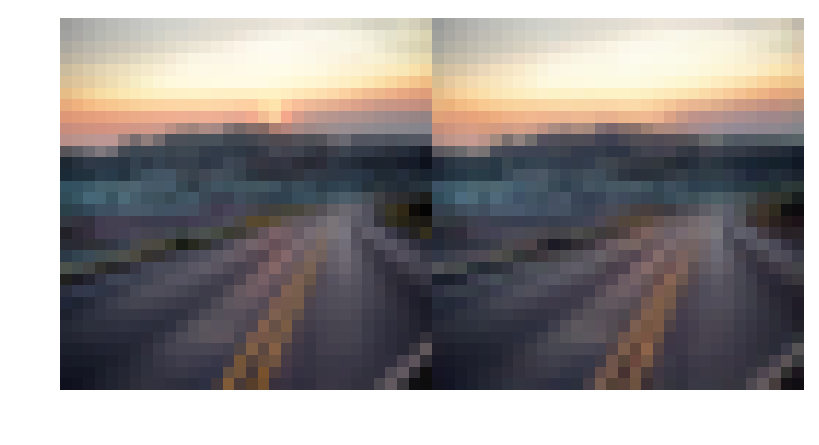

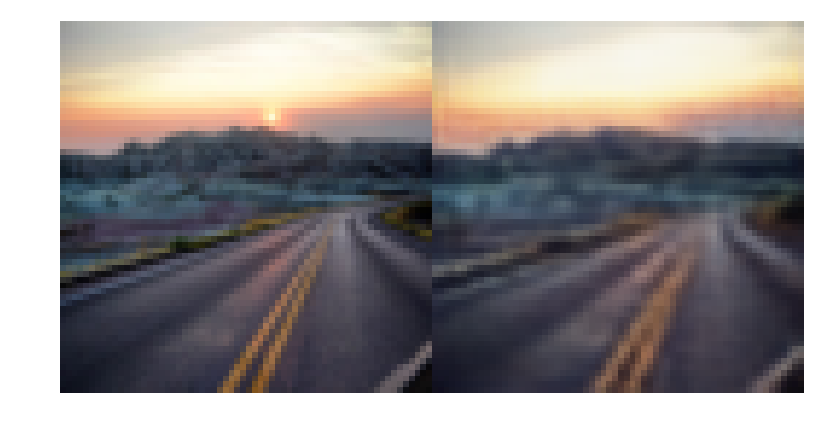

In [37]:
reconstruct(random.randint(0,TOTAL_BATCH-1))

## Latent  Animation

http://www.youtube.com/watch?v=grEi3uRlSb4
<table><tr>
<td><img src="https://s3.amazonaws.com/neurokinetikz/1542113809.6163912-109.gif"></td>
<td><img src="https://s3.amazonaws.com/neurokinetikz/1542113809.6163912-100.gif"></td>
<td><img src="https://s3.amazonaws.com/neurokinetikz/1542113809.6163912-080.gif"></td>
</tr></table>


In [40]:
def random_latents(n_imgs=3,steps=30):
    rimgs = np.random.permutation(FLAT)[:n_imgs]
    rimgs = np.append(rimgs, [rimgs[0]],axis=0)
    latent_animation(rimgs,steps,filename=str(time.time()))

def latent_animation(imgs=None,steps=None,filename="latent-animation"):
    
    # get latent encodings for images
    print('getting latent vectors ...')
    latents = []
    for index,img in enumerate(imgs):
        img = np.reshape(img,(-1,FEATURES))
        latent = ENCODER.predict_on_batch(img)
        latents.append(latent)

    # calculate latent path
    print('calculating latent path ...')
    latent_path = []
    for i in range(len(latents)-1):
        # get latent vectors
        l1 = latents[i] ; l2 = latents[i+1]

        # calculate latent distance
        image_distance = l2 - l1

        # create the latent path
        for j in range(steps):
            latent_path.append(l1 + j*image_distance/steps)
        latent_path.append(l2) 
    
    # reconstruct images along the path
    print('reconstructing latent paths... ')
    latent_path = np.reshape(latent_path,(-1,LATENT_DIM))
    recons = GENERATOR.predict_on_batch(latent_path)

    # de-normalize and clip the output
    final = np.clip((127.5*(recons+1)).reshape((-1,SIZE,SIZE,CHANNELS)),0,255)

    # build the gif
    gif.build_gif([utils.montage([r]).astype(np.uint8) for r in final], saveto=filename+".gif",dpi=32)
    
    recons = SUPER.predict_on_batch(latent_path)
    final = np.clip((127.5*(recons+1)).reshape((-1,SCALE_FACTOR*SIZE,SCALE_FACTOR*SIZE,CHANNELS)),0,255)
    gif.build_gif([utils.montage([r]).astype(np.uint8) for r in final], saveto=filename+"-2x.gif",dpi=32)

    # done
    print(filename)

getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008049.416835
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008076.9144473
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008103.9258192
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008130.7084856
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008157.5956392
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008184.3255377
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008211.4290774
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 
1543008238.7169685
getting latent vectors ...
calculating latent path ...
reconstructing latent paths... 


KeyboardInterrupt: 

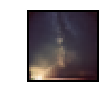

In [41]:
LATENT_DIM=512
for i in range(100):
    random_latents(5,30)

In [ ]:
imgs =  np.random.permutation(FLAT)
t = str(time.time())
for i in range(TOTAL_BATCH):
    print(i)
    latent_animation([imgs[i],imgs[i+1]],200,filename=t+'-'+ ('%03d' % i))

## Load Model & Continue Training 

In [ ]:
print('load model ...')
AUTOENCODER = load_model(MODEL_NAME+'-autoencoder-model.h5',
                         custom_objects={'vae_loss': vae_loss, 
                                         'R_SCALING':0.1, 
                                         'DSSIMObjective':DSSIMObjective()})

# define encoder
ENCODER = Model(inputs=[AUTOENCODER.input], outputs=[AUTOENCODER.get_layer("encoder").output])

# define generator
Z = Input(shape=(LATENT_DIM,))
GENERATOR = Model(inputs=[Z], outputs=[AUTOENCODER.get_layer("generator")(Z)])

ENCODER.compile(optimizer=ADAM,loss='mse')
GENERATOR.compile(optimizer=ADAM,loss='mse')

print('resume training ...')
AUTOENCODER.fit(x=FLAT,y=[FLAT,IMGS,FLAT,IMGS,FLAT],batch_size=BATCH_SIZE,epochs=EPOCHS,callbacks=[giffer,saver])

## Residual Channel Attention Network (RCAN) 

<img width=600 src="https://s3.amazonaws.com/neurokinetikz/Screen+Shot+2018-11-18+at+6.08.27+PM.png">

Convolutional neural network (CNN) depth is of crucial importance for image super-resolution (SR). However, we observe that deeper networks for image SR are more difficult to train. The low resolution inputs and features contain abundant low-frequency information, which is treated equally across channels, hence hindering the representational ability of CNNs. To solve these problems, we propose the very deep residual channel attention networks (RCAN). Specifically, we propose a residual in residual (RIR) structure to form very deep network, which consists of several residual groups with long skip connections. Each residual group contains some residual blocks with short skip connections. Meanwhile, RIR allows abundant low-frequency information to be bypassed through multiple skip connections, making the main network focus on learning high-frequency information. Furthermore, we propose a channel attention mechanism to adaptively rescale channel-wise features by considering interdependencies among channels. Extensive experiments show that our RCAN achieves better accuracy and visual improvements against state-of-the-art methods

### Residual Group 

In [12]:
def residual_group(x,x_g):
    # current layer
    current_layer = x ; generator = x_g
    
    # shortcuts
    shortcut = current_layer ; shortcut_g = generator
    
    for i in range(R_BLOCKS):
        # attention block
        current_layer, generator = attention_block(current_layer, generator)
        
        # final convolution
        if(i+1 == R_BLOCKS):
            conv = Conv2D(R_FILTERS,3,padding='SAME',kernel_initializer=INITIALIZER)
            current_layer = conv(current_layer) ; generator = conv(generator)
    
    merge = Add()
    current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])
    
    return current_layer, generator

### Residual Channel Attention Block (RCAB) 

<img width="500" src="https://s3.amazonaws.com/neurokinetikz/Screen+Shot+2018-11-18+at+6.06.32+PM.png">

In [13]:
def attention_block(x,x_g):
    # current layer
    current_layer = x ; generator = x_g
    
    # shortcuts
    shortcut = current_layer ; shortcut_g = generator
    
     # conv 1
    c1 = Conv2D(R_FILTERS,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c1(current_layer) ; generator = c1(generator)
    
    # activation 1
    a1 = Activation(ACTIVATION)
    current_layer = a1(current_layer) ; generator = a1(generator)

    # conv 2
    c2 = Conv2D(R_FILTERS,3,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c2(current_layer) ; generator = c2(generator)
    
    scale = Lambda(lambda x: x * R_SCALING)
    current_layer = scale(current_layer) ; generator = scale(generator)
    
    # channel attention
    current_layer, generator = channel_attention(current_layer,generator)
    
    # merge shortcut
    merge = Add()
    current_layer = merge([current_layer, shortcut]) ; generator = merge([generator, shortcut_g])
    
    return current_layer, generator

### Channel Attention 

In [14]:
def channel_attention(x,x_g):
    # current layer
    current_layer = x ; generator = x_g
    
    # shortcuts
    shortcut = current_layer ; shortcut_g = generator
    
    # global average pooling
    gp = GlobalAveragePooling2D()
    current_layer = gp(current_layer); generator = gp(generator);
    
    reshape = Reshape((1,1,R_FILTERS))
    current_layer = reshape(current_layer); generator = reshape(generator);
        
     # conv 1
    c1 = Conv2D(int(R_FILTERS/R_REDUCTION),1,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c1(current_layer) ; generator = c1(generator)

    # activation 1
    a = Activation(ACTIVATION)
    current_layer = a(current_layer) ; generator = a(generator)
    
    # conv 2
    c2 = Conv2D(R_FILTERS,1,padding='SAME',kernel_initializer=INITIALIZER)
    current_layer = c2(current_layer) ; generator = c2(generator)
    
    # residual scaling
    scale = Lambda(lambda x: x * R_SCALING)
    current_layer = scale(current_layer) ; generator = scale(generator)
    
    # sigmoid activation
    s = Activation("sigmoid")
    current_layer = s(current_layer) ; generator = s(generator)
    
    # merge shortcut
    m = Multiply()
    current_layer = m([current_layer,shortcut]) ; generator = m([generator,shortcut_g])
    
    return current_layer, generator
    